In [1]:
import torch
import torch.nn as nn

In [2]:
import opendatasets as od

In [3]:
torch.__version__

'2.1.0.dev20230729'

In [4]:
device = "mps"

In [5]:
od.download("https://www.kaggle.com/datasets/grassknoted/asl-alphabet")

Skipping, found downloaded files in "./asl-alphabet" (use force=True to force download)


In [6]:
from pathlib import Path

train_dir = Path("asl-alphabet/asl_alphabet_train/asl_alphabet_train")
test_dir = Path("asl-alphabet/asl_alphabet_test/asl_alphabet_test")
image_path = Path("asl-alphabet/")

train_dir, test_dir

(PosixPath('asl-alphabet/asl_alphabet_train/asl_alphabet_train'),
 PosixPath('asl-alphabet/asl_alphabet_test/asl_alphabet_test'))

Random image path: asl-alphabet/asl_alphabet_test/asl_alphabet_test/S_test.jpg
Image class: asl-alphabet/asl_alphabet_test/asl_alphabet_test/S_test.jpg
Image height: 200
Image width: 200


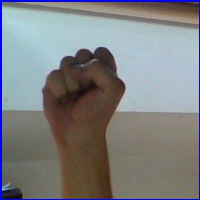

In [7]:
import random
from PIL import Image
import glob

# Set seed
random.seed(21) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadatad
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [8]:
import numpy as np

img_arr = np.asarray(img)

img_arr.shape

(200, 200, 3)

In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [10]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [11]:
from torchvision import datasets

data = datasets.ImageFolder(root = train_dir,
                                 transform = data_transform)

In [12]:
print(f"Train data:\n{data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 87000
    Root location: asl-alphabet/asl_alphabet_train/asl_alphabet_train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [13]:
class_names = data.classes
class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [14]:
train_size = int(0.8*len(data))
test_size = len(data)-train_size
train_data, test_data = torch.utils.data.random_split(data, [train_size,test_size])

In [15]:
len(train_data), len(test_data)

(69600, 17400)

In [16]:
img, label = train_data[3001][0], train_data[3001][1]
print(img.shape)
print(img.dtype)
print(label)

torch.Size([3, 64, 64])
torch.float32
4


In [17]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset = train_data,
                    batch_size = 32,
                    shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                    batch_size = 32,
                    shuffle=False)


train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x127d08e50>,
 <torch.utils.data.dataloader.DataLoader at 0x142bbac50>)

In [18]:
img, label = next(iter(train_dataloader))
print(img.shape)
print(label)

torch.Size([32, 3, 64, 64])
tensor([ 0,  4, 17, 20, 19,  7, 26, 28,  0, 11,  8,  0, 25, 14,  2, 18,  8, 22,
        22, 17,  1, 23, 18,  5, 11,  7,  2, 21, 21, 28,  0, 18])


In [19]:
class network(nn.Module):
    
    def __init__(self, input_channels: int, output_channels: int):
        super().__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(input_channels,8,3,1,1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            #nn.MaxPool2d(2,stride=2),
            nn.Conv2d(8,8,3,1,1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2))
            
        self.convblock2 = nn.Sequential(
            nn.Conv2d(8,16,3,1,1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            nn.Conv2d(16,16,3,1,1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16,32,3,1,1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2))
   
        
        self.fcblock = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8*8*32,32),
            nn.Dropout(p=0.2),
            nn.Linear(32,output_channels)
        )
        
    def forward(self, x: torch.Tensor):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.fcblock(x)
        return x

torch.manual_seed(21)
model = network(3,len(data.classes)).to(device)
model

network(
  (convblock1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride

In [20]:
from torchinfo import summary
summary(model, input_size = [1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
network                                  [1, 29]                   --
├─Sequential: 1-1                        [1, 8, 32, 32]            --
│    └─Conv2d: 2-1                       [1, 8, 64, 64]            224
│    └─BatchNorm2d: 2-2                  [1, 8, 64, 64]            16
│    └─ReLU: 2-3                         [1, 8, 64, 64]            --
│    └─Conv2d: 2-4                       [1, 8, 64, 64]            584
│    └─BatchNorm2d: 2-5                  [1, 8, 64, 64]            16
│    └─ReLU: 2-6                         [1, 8, 64, 64]            --
│    └─MaxPool2d: 2-7                    [1, 8, 32, 32]            --
├─Sequential: 1-2                        [1, 32, 8, 8]             --
│    └─Conv2d: 2-8                       [1, 16, 32, 32]           1,168
│    └─BatchNorm2d: 2-9                  [1, 16, 32, 32]           32
│    └─ReLU: 2-10                        [1, 16, 32, 32]           --
│    └─Max

In [21]:
def train_step(model: torch.nn.Module,
         data: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module, 
         optimizer: torch.optim.Optimizer):
    
    model.train()
    
    train_loss, train_acc = 0, 0
    
    for batch, (X,y) in enumerate(data):
        
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        
        loss = loss_fn(y_pred,y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(data)
    train_acc = train_acc / len(data)
    return train_loss, train_acc

In [22]:
def test_step(model: torch.nn.Module, 
              data: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):

    model.eval() 
    

    test_loss, test_acc = 0, 0
    
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(data):
            
            X, y = X.to(device), y.to(device)
                
            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_class = test_pred.argmax(dim=1)
            test_acc += ((test_pred_class == y).sum().item()/len(test_pred_class))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(data)
    test_acc = test_acc / len(data)
    return test_loss, test_acc

In [23]:
!pip install tqdm

In [24]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_data: torch.utils.data.DataLoader, 
          test_data: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    #for epochs in range(epochs_i,epochs_f+1):
       # print("For", epochs, "iterations")
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                            data=train_data,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                data=test_data,
                loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
                )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

# GPU Runtime 

In [25]:
device = "mps"
device

'mps'

In [26]:
torch.manual_seed(21) 
torch.cuda.manual_seed(21)
                       
model = network(3,len(data.classes)).to(device)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

from timeit import default_timer as timer 
start_time = timer()

model_results = train(model=model, 
                        train_data=train_dataloader,
                        test_data=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=5)
                       

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1159 | train_acc: 0.6347 | test_loss: 0.3656 | test_acc: 0.8841
Epoch: 2 | train_loss: 0.3577 | train_acc: 0.8754 | test_loss: 0.2628 | test_acc: 0.9065
Epoch: 3 | train_loss: 0.2203 | train_acc: 0.9224 | test_loss: 0.2516 | test_acc: 0.9237
Epoch: 4 | train_loss: 0.1651 | train_acc: 0.9423 | test_loss: 0.1062 | test_acc: 0.9608
Epoch: 5 | train_loss: 0.1301 | train_acc: 0.9548 | test_loss: 0.1097 | test_acc: 0.9623
Total training time: 390.691 seconds


# CPU Runtime 

In [27]:
device = "cpu"
device

'cpu'

In [28]:
torch.manual_seed(21) 
torch.cuda.manual_seed(21)
                       
model = network(3,len(data.classes)).to(device)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

from timeit import default_timer as timer 
start_time = timer()

model_results = train(model=model, 
                        train_data=train_dataloader,
                        test_data=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=5)
                       

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1621 | train_acc: 0.6202 | test_loss: 0.5421 | test_acc: 0.8166
Epoch: 2 | train_loss: 0.3669 | train_acc: 0.8727 | test_loss: 0.2843 | test_acc: 0.8916
Epoch: 3 | train_loss: 0.2181 | train_acc: 0.9231 | test_loss: 0.1937 | test_acc: 0.9333
Epoch: 4 | train_loss: 0.1632 | train_acc: 0.9422 | test_loss: 0.1049 | test_acc: 0.9649
Epoch: 5 | train_loss: 0.1271 | train_acc: 0.9561 | test_loss: 0.1817 | test_acc: 0.9345
Total training time: 991.841 seconds
